# **DTSA-5511-M3. CNN Cancer Detection**

This notebook was created for the University of Colorado Boulder class DTSA-5511, Module 3. It's based on a Kaggle competition that ended in 2019.

# **Challenge**

The challenge in this Kaggle competition is to create a machine-learning model that can identify metastatic cancer in small image patches taken from larger digital pathology scans. 


# **About the data**

The data consists of a training set of 220,025 images and a testing set of 57,458 images. 

Each image is stored in a file named with an image ID. The file train_labels.csv contains the IDs and true labels of the training images.

All images are in .tif format and are of size 96 x 96 pixel. 

An image counts as positive (class 1) if the center 32 x 32 pixel region contains at least one pixel of tumor tissue. Tumor tissue outside of this central region does not affect the label.


# **Approach**

We will evaluate three different model architectures, of different complexities

The simplest model has a single convolutional layer. 

The intermediate model has two convolutional layers, and also batch normalization and dropout.

The deeper model has three convolutional layers, with batch normalization and dropout.

As we’re dealing with a binary classification task, we will use a sigmoid activation function in the output layer in all three models.

For the exact model architectures, see the section Model below.

We expect that the simple model won't be able to catch all complex and nuanced patterns. The two deeper models should be better at catching such patterns, but at the risk of overfitting.

We will use Adam as our optimizer, as it’s powerful and widely used. 

To speed up hyper-parameter tuning, we will initially train the model on just 20% of the training data. Most hyper-parameters will initially be set to their defaults.

We will measure three metrics: accuracy, AUC (Area under ROC curve), and loss.

# **Libraries**

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
import pickle
import random
import json 
import os
import re

from PIL import Image
from PIL import ImageDraw

# from tqdm import tqdm
# from tqdm.keras import TqdmCallback
# train_on_gpu = True

# from collections import Counter

from IPython.display import FileLink

import tensorflow as tf

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import tensorflow_io as tfio

In [2]:
# Supress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Initialize TPU, if detected
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Get TPU resolver
    tf.config.experimental_connect_to_cluster(tpu)  # Connect to TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)  # Initialize TPU system
    strategy = tf.distribute.TPUStrategy(tpu)  # Create a distribution strategy
    print("Running on TPU")
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU and single GPU
    print("Running on GPU/CPU")

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on GPU/CPU
Number of accelerators:  1


# **Directories**

In [4]:
# Directory names
main_dir = '/kaggle/input/histopathologic-cancer-detection/'
train_dir = os.path.join(main_dir, 'train/')
test_dir = os.path.join(main_dir, 'test/')

# **Load the data**

The provided data doesn't require any cleaning. 

For convenience, we will add .tif to the image IDs, so that the IDs can be used directly to retrieve the image files.

In [5]:
# Load the training id:s and labels
train_ids_full = pd.read_csv(main_dir + 'train_labels.csv')

# Load the test id:s
test_ids = pd.read_csv(main_dir + 'sample_submission.csv').drop('label', axis = 1)

# Print number of images
print(f"Number of training images: {train_ids_full.shape[0]}.")
print(f"Number of testing images: {test_ids.shape[0]}.")

Number of training images: 220025.
Number of testing images: 57458.


In [6]:
# Take a look at the dataframes
display(train_ids_full.head())
display(test_ids.head())

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


,id
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5
1,95596b92e5066c5c52466c90b69ff089b39f2737
2,248e6738860e2ebcf6258cdc1f32f299e0c76914
3,2c35657e312966e9294eac6841726ff3a748febf
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6


In [7]:
# Add ".tif" to the id:s (unless it's already been done)
if train_ids_full['id'][0][-4:] != '.tif':
    train_ids_full['id'] = train_ids_full['id'] + '.tif'
    
if test_ids['id'][0][-4:] != '.tif':
    test_ids['id'] = test_ids['id'] + '.tif'
    
# Check the results
display(train_ids_full.head())
display(test_ids.head())

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


,id
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


# **EDA**

## Class distribution

As we can see in the graph below, the classes are somewhat unbalanced, with more negative examples (i.e. no cancer; label 0), than positive examples (i.e cancer; label 1). To address this, we will weight the classes when training the model.



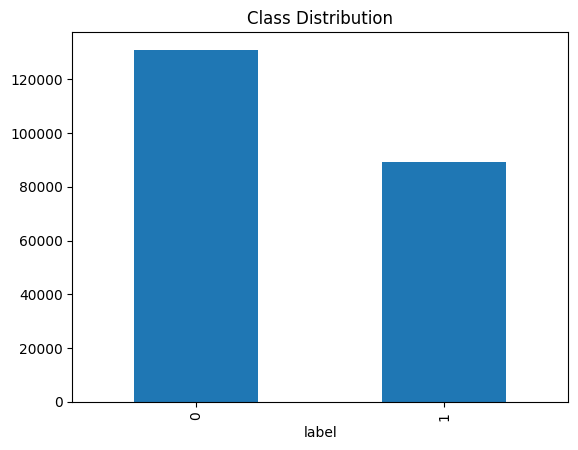

In [8]:
# Plot class distribution
train_ids_full['label'].value_counts().plot(kind = 'bar')
plt.title('Class Distribution')
plt.show()

## Some sample images

Below, we output eight images from each class. A quick look at the images should confirm that there is no obvious way (at least not for a layperson) to distinguish the classes from each other.

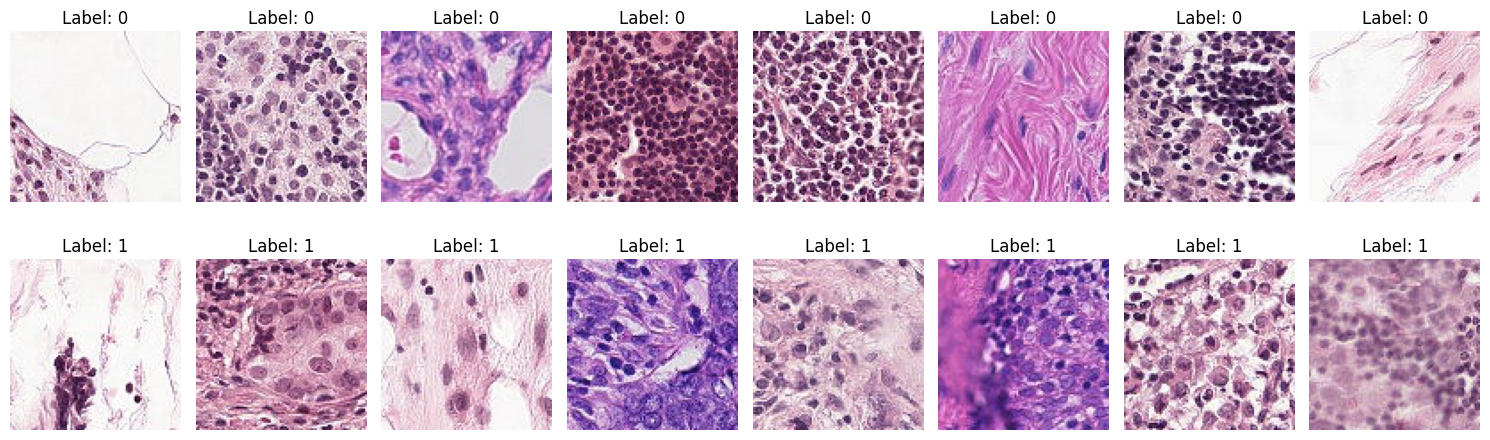

In [9]:
# Set up a grid of 2 rows and 8 columns
fig, axes = plt.subplots(2, 8, figsize = (15, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Display 5 images of each class
i = 0 # Indes for the axes array
for label in [0, 1]:
    sample_ids = train_ids_full[train_ids_full['label'] == label]['id'].head(8)
    for img_id in sample_ids:
        img_path = train_dir + img_id
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off') # Hide the axes ticks
        i += 1 # Move to the next subplot
        
plt.tight_layout()
plt.show()

# **Configuration**

We'll create a configuration dictionary, so that we can set all the configurations we aim at tuning in one place. At the end of the notebook, this dictionary is merged with the final validation results and stored in a config_and_results object. The stored objects from multiple models will be imported into a dataframe, so that we can see how the hyper-parameter tuning affects the results.

In [10]:
config = {
    'sample_fraction': 1, # Start with 0.1 and increase to 0.2 and finally 1
    'batch': 24, # Start with 32
    'model': 'deeper_model', # simple_model, intermediate_model, deeper_model
    'learning_rate': 0.0001, # Default for Adam: 0.001
    'beta_1': 0.9, # Default for Adam: 0.9
    'beta_2': 0.999, # Default for Adam: 0.999
    'clipnorm': None, # Default for Adam: None
    'kernel_regularizer': l2(0.003), # Default for Conv2D: None
    'optimizer': 'Adam',
    'metrics': ['accuracy', 'AUC'], # 'accuracy' and/or 'AUC'. Default: None
    'monitor': 'val_loss', # 'val_loss' or 'val_AUC'
    'patience': 3, # Start with 5
    'epochs': 30 # We'll use early stopping, so we don't expect 30 epochs.
}

# **Take a portion of the data**

To speed up early hyper-parameter tuning, we'll start by training the model on just a portion of the training set. As we continue fine-tuning the hyper-parameters, we'll increase this portion until we finally run the model on the entire training set.

In [11]:
# Take just a portion of the data
train_ids_selected = train_ids_full.sample(frac = config['sample_fraction'], random_state = 42)

# Verify the sample
print(f'Full training set: {len(train_ids_full)}')
print(f'Sampled training set: {len(train_ids_selected)}')

Full training set: 220025
Sampled training set: 220025


# **Split the training data into training and validation sets**

In [12]:
# Split training data into training and temp (validation/testing) sets.
train_ids, val_ids = train_test_split(train_ids_selected, test_size = 0.2, random_state = 42)

# Check the sizes of the splits
print(f'Training set size: {len(train_ids)}')
print(f'Validation set size: {len(val_ids)}')

Training set size: 176020
Validation set size: 44005


# **Prepare data for the model**

We'll prepare the data so that it can be efficiently used for training on TPU. 

Due to issues when running on TPU, we eventually settled for GPU, but the data format generated below works weither we train on CPU, GPU, or TPU.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess(image, label=None):
    image = tf.io.read_file(image)
    image = tfio.experimental.image.decode_tiff(image)  # Decode TIFF image
    image = tf.image.resize(image, [96, 96])  # Resize to target size (just in case)
    
    # Ensure the image has 3 channels (discard alpha channel if present)
    image = image[..., :3]  # Select only the first 3 channels (RGB)
    
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    
    if label is not None:
        return image, label
    return image

In [14]:
# Training data
train_paths = train_ids['id'].apply(lambda x: f"{train_dir}/{x}").values
train_labels = train_ids['label'].astype('int32').values

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(config['batch']).prefetch(buffer_size=AUTOTUNE)

In [15]:
# Validation data
val_paths = val_ids['id'].apply(lambda x: f"{train_dir}/{x}").values
val_labels = val_ids['label'].astype('int32').values

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(config['batch']).prefetch(buffer_size=AUTOTUNE)

In [16]:
# Testing data
test_paths = test_ids['id'].apply(lambda x: f"{test_dir}/{x}").values

# Test dataset (no shuffling, as we want to keep the order)
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(lambda x: preprocess(x, None), num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(config['batch']).prefetch(buffer_size=AUTOTUNE)

# **Model**
We will try three different model architectures:
* a simple model with a single Conv2D layer,
* an intermediate model with two Conv2D layers, batch normalization, and dropout
* a deeper model, with three Conv2D layers, batch normalization, and dropout

In [17]:
# A simple model with a single Conv2D layer,
def simple_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),  # Use an Input layer here
        
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# An intermediate model with two Conv2D layers, batch normalization, and dropout
def intermediate_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(), 
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# A deeper model, with three Conv2D layers, batch normalization, and dropout
def deeper_model():
    model = Sequential([
        Input(shape=(96, 96, 3)),
        
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer = config['kernel_regularizer']),
        BatchNormalization(),  # Add batch normalization after convolutional layers
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer = config['kernel_regularizer']),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer = config['kernel_regularizer']),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer = config['kernel_regularizer']),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer = config['kernel_regularizer']),
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [18]:
# Generate and compile a model based the chosen configs
with strategy.scope():
    if config['model'] == 'simple_model':
        model = simple_model()
    elif config['model'] == 'intermediate_model':
        model = intermediate_model()
    elif config['model'] == 'deeper_model':
        model = deeper_model()
    else:
        print("Invalid model selection.")

    # Initialize the optimizer with the learning rate
    if config['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate = config['learning_rate'],
                         beta_1 = config['beta_1'],
                         beta_2 = config['beta_2'],
                         clipnorm = config['clipnorm'])
    else:
        print("Invalid optimizer selection")
    
    # Compile the model
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy', # Appropriate for binary classifcation tasks
                  metrics = config['metrics'])

    # Display the model summary
    model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,740,993 (6.64 MB)

 Trainable params: 1,740,545 (6.64 MB)

 Non-trainable params: 448 (1.75 KB)

# **Custom logger**
This custom logger will be used to display the progress during the training.

In [19]:
class ProgressLogger(Callback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) 
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1} starting...")

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.epoch_start_time
        print(f"Epoch {epoch+1} ended. Elapsed time: {elapsed_time:.2f} seconds")
        print(f"Logs: {logs}")
        
        # Save the current epoch number to a file
        with open('epoch_log.json', 'w') as f:
            json.dump({'last_epoch': epoch + 1}, f)

    def on_batch_end(self, batch, logs=None):
        if batch % 100 == 0:  # Print progress every 100 batches
            print(f"\nProcessing batch {batch}")

# **Train the model**

We'll use class weights to address the class imbalance in the training data.

We'll use early stopping, to shorten computation time and to prevent over-fitting.

In [20]:
# Calculate the weight of each class
class_0_count, class_1_count = train_ids['label'].value_counts()
total_count = class_0_count + class_1_count

# Set the class weights inversely proportional to class frequencies
class_weights = {
    0: total_count / (2 * class_0_count),
    1: total_count / (2 * class_1_count)
}

In [21]:
%%time
# Early stopping, to prevent overfitting
early_stopping = EarlyStopping(monitor = config['monitor'], 
                               patience = config['patience'], 
                               restore_best_weights = True)
    
# Train the model with the custom callback
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = config['epochs'],
    class_weight = class_weights,
    callbacks = [ProgressLogger(), early_stopping],
)



Epoch 1 starting...
Epoch 1/30


I0000 00:00:1729626402.709943      97 service.cc:145] XLA service 0x7873f0006bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729626402.709983      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0



Processing batch 0
  10/7335 ━━━━━━━━━━━━━━━━━━━━ 1:36 13ms/step - AUC: 0.5764 - accuracy: 0.5132 - loss: 2.2712 

I0000 00:00:1729626407.986522      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 100/7335 ━━━━━━━━━━━━━━━━━━━━ 6:05 51ms/step - AUC: 0.7126 - accuracy: 0.6518 - loss: 2.1106
Processing batch 100
 200/7335 ━━━━━━━━━━━━━━━━━━━━ 6:08 52ms/step - AUC: 0.7418 - accuracy: 0.6749 - loss: 2.0638
Processing batch 200
 300/7335 ━━━━━━━━━━━━━━━━━━━━ 6:07 52ms/step - AUC: 0.7588 - accuracy: 0.6883 - loss: 2.0313
Processing batch 300
 400/7335 ━━━━━━━━━━━━━━━━━━━━ 6:03 52ms/step - AUC: 0.7714 - accuracy: 0.6990 - loss: 2.0049
Processing batch 400
 500/7335 ━━━━━━━━━━━━━━━━━━━━ 5:58 52ms/step - AUC: 0.7801 - accuracy: 0.7063 - loss: 1.9837
Processing batch 500
 600/7335 ━━━━━━━━━━━━━━━━━━━━ 5:51 52ms/step - AUC: 0.7869 - accuracy: 0.7123 - loss: 1.9654
Processing batch 600
 700/7335 ━━━━━━━━━━━━━━━━━━━━ 5:43 52ms/step - AUC: 0.7922 - accuracy: 0.7172 - loss: 1.9491
Processing batch 700
 800/7335 ━━━━━━━━━━━━━━━━━━━━ 5:37 52ms/step - AUC: 0.7965 - accuracy: 0.7214 - loss: 1.9342
Processing batch 800
 900/7335 ━━━━━━━━━━━━━━━━━━━━ 5:36 52ms/step - AUC: 0.8004 - accuracy: 0.7251 -

In [22]:
# Extract final validation accuracy, AUC, and loss
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_auc = history.history['val_AUC'][-1]  
final_val_loss = history.history['val_loss'][-1]

print()
print(f"Final Validation accuracy: {final_val_accuracy}")
print(f"Final Validation AUC: {final_val_auc}")
print(f"Final Validation Loss: {final_val_loss}")


Final Validation accuracy: 0.8957391381263733
Final Validation AUC: 0.951860249042511
Final Validation Loss: 0.3832809627056122


# **Make predictions, and generate submission file**

In [23]:
%%time
# Make predictions on the test data
predictions = model.predict(test_dataset, verbose = 1)

2395/2395 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step
CPU times: user 37.1 s, sys: 7.67 s, total: 44.8 s
Wall time: 1min 13s


In [24]:
# The sample_submission file contains the test id:s
submission = pd.read_csv(main_dir + 'sample_submission.csv')

# Enter the predictions into the "label" column.
# (The instructions says that this column should contain probabilities, but be named "labels". 
# Not an ideal arrangement, in my mind.)
submission['label'] = predictions

# Take a look
submission[:5]

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.038086
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.602323
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.088783
3,2c35657e312966e9294eac6841726ff3a748febf,0.088344
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.091665


In [25]:
# Generate a timestamp, to be used in the file names of all generated files
timestamp = datetime.now().strftime('%Y-%m-%d_%H%M')

In [26]:
# File name for the submission file
submission_f = f'submission_{timestamp}.csv'

# Generate the submission file
# A download link will be generated at the end of the notebook.
submission.to_csv(submission_f, index = False)

# **Save configs and results**

In [27]:
# Create a new dictionary, to hold both configs and final validation results
config_and_results = config

# Replace the kernel_regularizer with a string
if str(type(config_and_results['kernel_regularizer'])) == "<class 'keras.src.regularizers.regularizers.L2'>":
    config_and_results['kernel_regularizer'] = f"L2({config['kernel_regularizer'].l2})"

# Add final validation values to the dictionary
config_and_results['final_val_accuracy'] = final_val_accuracy
config_and_results['final_val_auc'] = final_val_auc
config_and_results['final_val_loss'] = final_val_loss

# File name for the config_and_results file
config_and_results_f = f'config_and_results_{timestamp}.json'

# Generate a JSON object with the configs and the results. 
# A download link will be generated at the end of the notebook.
with open(config_and_results_f, 'w') as f:
    json.dump(config_and_results, f, indent = 4)

# **Generate plots**

To evaluate our hyper-parameters, we'll generate plots to show how validation accuracy, AUC, and loss changes over the epochs.

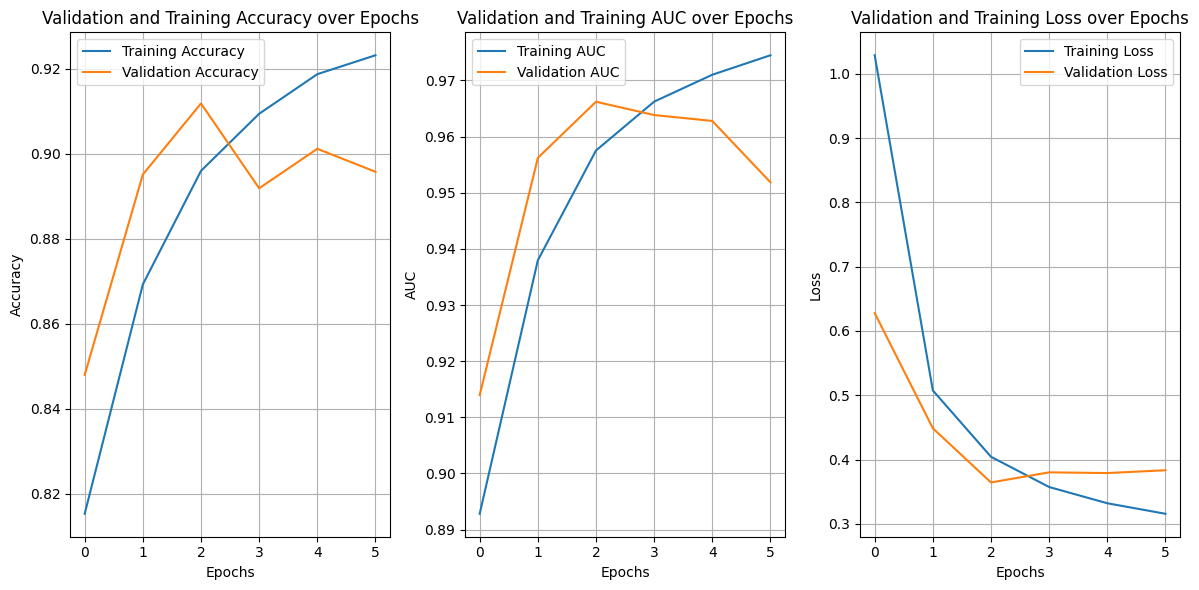

In [28]:
# Extract the training and validation accuracy
val_accuracy_per_epoch = history.history['val_accuracy']
train_accuracy_per_epoch = history.history['accuracy']

# Extract the training and validation AUC
val_auc_per_epoch = history.history['val_AUC']
train_auc_per_epoch = history.history['AUC']

# Extract the training and validation loss
val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']

# Set up a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Plot the training and validation accuracy
ax1.plot(train_accuracy_per_epoch, label='Training Accuracy')
ax1.plot(val_accuracy_per_epoch, label='Validation Accuracy')
ax1.set_title('Validation and Training Accuracy over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

# Plot the training and validation AUC 
ax2.plot(train_auc_per_epoch, label='Training AUC')
ax2.plot(val_auc_per_epoch, label='Validation AUC')
ax2.set_title('Validation and Training AUC over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.grid(True)
ax2.legend()

# Plot the training and validation loss
ax3.plot(train_loss_per_epoch, label='Training Loss')
ax3.plot(val_loss_per_epoch, label='Validation Loss')
ax3.set_title('Validation and Training Loss over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.grid(True)
ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot with a unique timestamp
acc_auc_loss_plots_f = f'acc_auc_loss_plots_{timestamp}.png'

# Save the plot. 
# A download link will be generated at the end of the notebook.
plt.savefig(acc_auc_loss_plots_f)

# Show the plot
plt.show()

# **Gather the configs and results for all models so far in a dataframe**

To make it easy to see how the hyper-parameter tuning affects the results, we will gather the data from configs_and_results from all runs so far into a single dataframe.

In [29]:
# Define the base directory where the JSON files are stored
base_dir = "/kaggle/working"  # Change this to your actual base directory

# List to store each run's data
all_runs_data = []

# Loop through each file in the base directory
for file in os.listdir(base_dir):
    json_file_path = os.path.join(base_dir, file)

    # Only proceed if it's a JSON file that starts with "config_and_results"
    if file.startswith("config_and_results") and file.endswith(".json"):
        # Extract the date and time part from the file name
        date_time_part = file.replace("config_and_results_", "").replace(".json", "")
        
        # Read the JSON file
        with open(json_file_path, 'r') as json_file:
            config_and_results = json.load(json_file)
            config_and_results['date_time'] = date_time_part  # Add the date and time to the data
            all_runs_data.append(config_and_results)

# Convert the list of dictionaries into a Pandas DataFrame
all_runs_summary = pd.DataFrame(all_runs_data)

# Move the 'date_time' column to the first position
all_runs_summary = all_runs_summary[['date_time'] + [col for col in all_runs_summary.columns if col != 'date_time']]

# Sort dataframe by data_tiem
all_runs_summary.sort_values(by = 'date_time', inplace = True)

# File name for the submission file
all_runs_summary_f = f'all_runs_summary_{timestamp}.csv'

# Save the DataFrame to a CSV file. 
# A download link will be generated at the end of the notebook.
all_runs_summary.to_csv(all_runs_summary_f, index=False)

# **Download links**
These links make it easy to download the results to your local machine.

In [31]:
# Download link for configs and results from this run
FileLink(rf'{config_and_results_f}')

/kaggle/working/config_and_results_2024-10-22_2003.json

In [32]:
# Download link for the submission file
FileLink(rf'{submission_f}')

/kaggle/working/submission_2024-10-22_2003.csv

In [33]:
# Download link for the plot showing changes over epochs
FileLink(acc_auc_loss_plots_f)

/kaggle/working/acc_auc_loss_plots_2024-10-22_2003.png

In [34]:
# Download link for the table with summary of configs and results from all runs
FileLink(rf'{all_runs_summary_f}')

/kaggle/working/all_runs_summary_2024-10-22_2003.csv

# **Results and discussion**

We trained a total of 11 models. The table below shows the hyper-parameters and results for each model. The cells highlighted in yellow shows parameters that were changed from the previous model. The cells highligthed in green shows the best metrics (which we achieved on the final run).

**Columns**
* date_time: When the model was trained. Used as an identifier.
* sample_fraction: The portion of the training data was used when training the model.
* batch: Batch size.
* model: Which of the three model architectures that was used.
* learning_rate: The learning rate
* kernel_regularization: What kernel regularization was used. Empty cell means none.
* patience: What patience was used for early stopping.
* final_val_accuracy: The final validation accuracy.
* final_val_auc: The final validation AUC (Area under ROC curve)
* final_val_loss: The final validation loss.

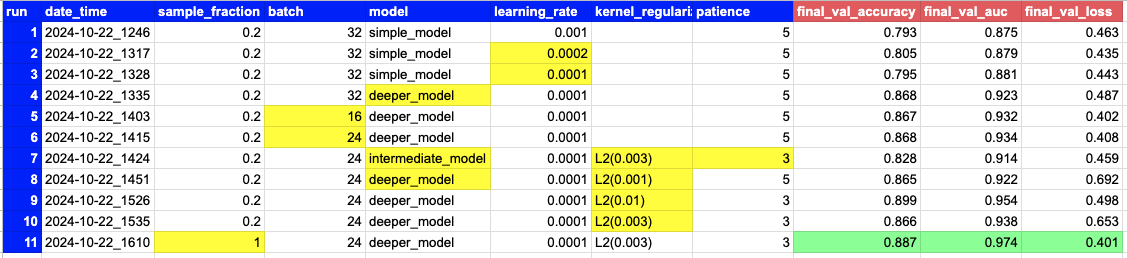

The decision on which hyper-parameter to change was decided based on inspecting the plots of show how accuracy, AUC, and loss changed over the epochs. 

The initial training rate seemed to be too high, as there was a lot of fluctuations in the curves.

The deeper model turned out to be better than the simle and intermediate ones.

There was still some instability. Adding L2 regularization lead to some improvement.

Finally, training the model on the entire training set, rather than on just 20% of it, led to a significant improvement.

The plots below are for the final model (trained on the entire training set). The fluctuations in the curves indicate that the learning rate might still be too high.

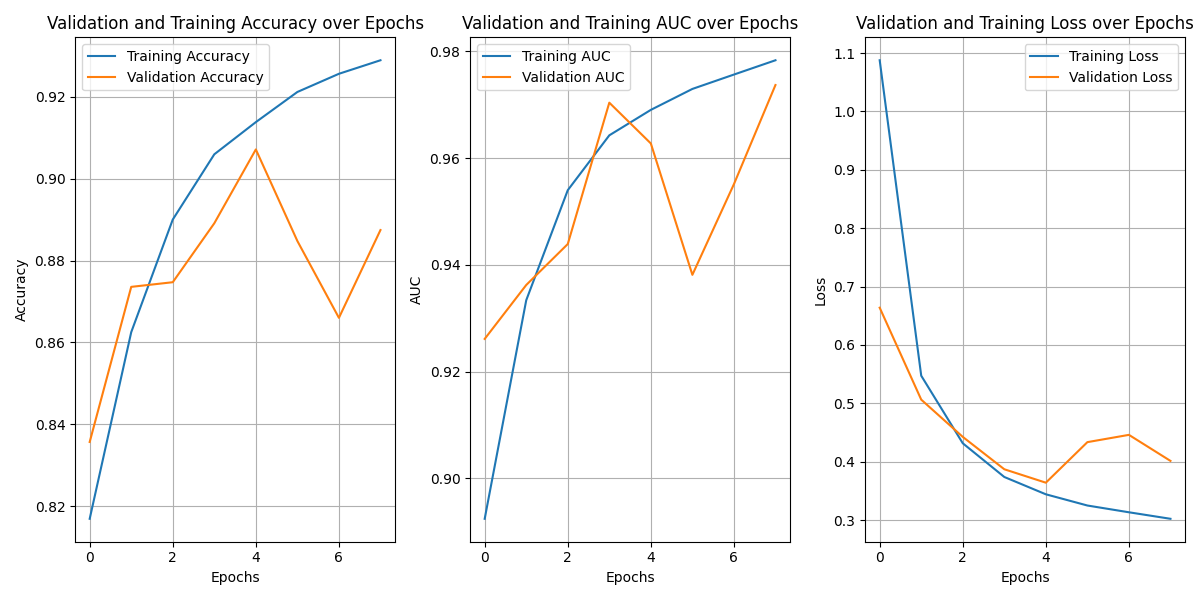

If we had had the time and resources to train further models, we would have explored:
* lowering the training rate further,
* using other optimizers, e.g. SGD or RMSprop

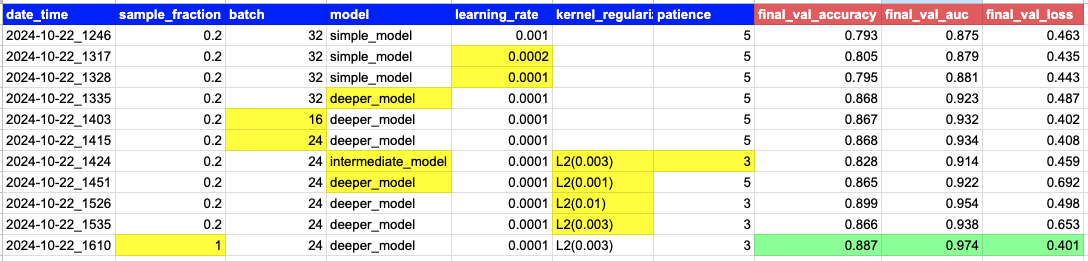
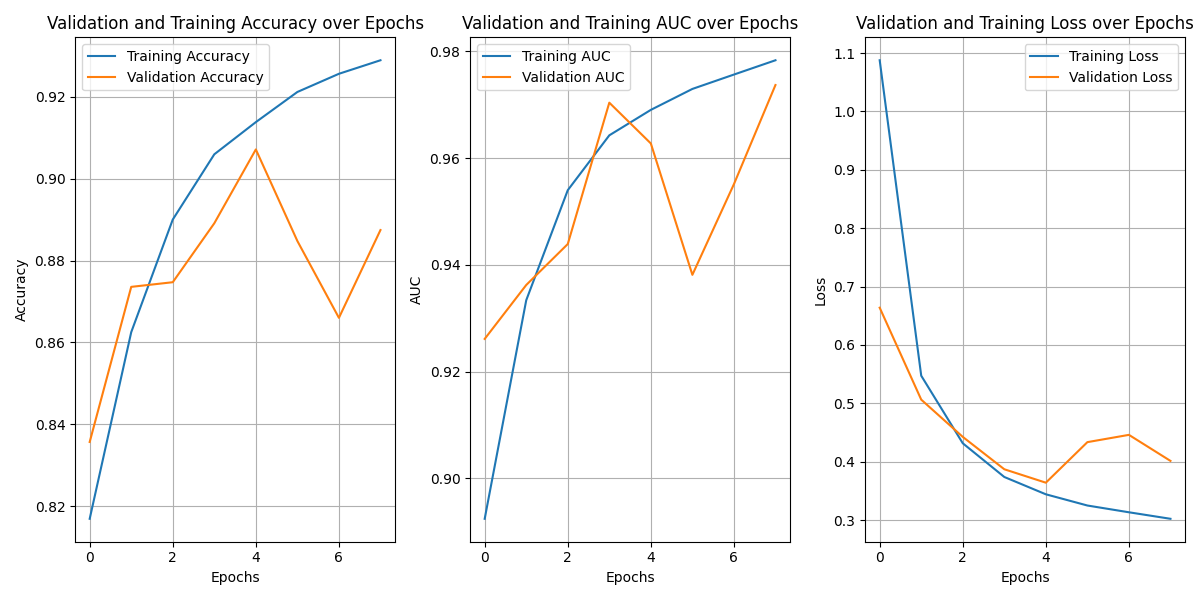